# Logistic Regression for cat classifier

**Import necessary packages**

In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt

**Load training data**


In [2]:
def load_dataset():
    train_dataset = h5py.File('datasets/train_catvnoncat.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('datasets/test_catvnoncat.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes


In [3]:
# Loading the data (cat/non-cat)
train_x_orig, train_y, test_x_orig, test_y, classes = load_dataset()

**Matplotlib can be used to display the image**

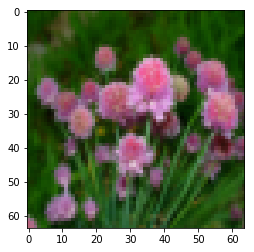

In [4]:
plt.imshow(train_x_orig[21])

In [5]:
m_train = train_x_orig.shape[0]
m_test = test_x_orig.shape[0]
num_px = train_x_orig.shape[1]

print ("Number of training examples: m_train = " + str(m_train))
print ("Number of testing examples: m_test = " + str(m_test))
print ("Height/Width of each image: num_px = " + str(num_px))
print ("train_x shape: " + str(train_x_orig.shape))

Number of training examples: m_train = 209
Number of testing examples: m_test = 50
Height/Width of each image: num_px = 64
train_x shape: (209, 64, 64, 3)


**Flatten training and test data sets**

In [6]:
train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0],-1).T
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0],-1).T

 **Standardize dataset**

In [7]:
train_x = train_x_flatten/255.
test_x = test_x_flatten/255.

### Helper Functions

In [8]:
def sigmoid(Z):
    A = 1/(1+np.exp(-Z))
    cache = Z
    
    return A, cache

In [9]:
def sigmoidBackward(dA, cache):
    Z = cache
    s = 1/(1+np.exp(-Z))
    dZ = dA * s * (1-s)
    
    assert (dZ.shape == Z.shape)
    
    return dZ

In [10]:
def relu(Z):
    A = np.maximum(0,Z)
    assert(A.shape == Z.shape)
    cache = Z 
    
    return A, cache

In [11]:
def reluBackward(dA, cache):
    Z = cache
    dZ = np.array(dA, copy=True) 
    
    dZ[Z <= 0] = 0
    
    assert (dZ.shape == Z.shape)
    
    return dZ

In [12]:
def initializeParameters(layer_dims):
    parameters = {}
    L = len(layer_dims)
    np.random.seed(1)
    
    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) / np.sqrt(layer_dims[l-1])
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))
        
        assert(parameters['W' + str(l)].shape == (layer_dims[l], layer_dims[l-1]))
        assert(parameters['b' + str(l)].shape == (layer_dims[l], 1))

    return parameters

In [13]:
def linearForward(A, W, b):
    Z = W.dot(A) + b
    
    assert(Z.shape == (W.shape[0], A.shape[1]))
    cache = (A, W, b)
    
    return Z, cache

In [14]:
def linearActivationForward(A_prev, W, b, activation):
    Z, linear_cache = linearForward(A_prev, W, b)
    if activation == "sigmoid":
        A, activation_cache = sigmoid(Z)
    elif activation == "relu":
        A, activation_cache = relu(Z)
    
    assert (A.shape == (W.shape[0], A_prev.shape[1]))
    cache = (linear_cache, activation_cache)

    return A, cache

In [15]:
def forwardPropogate(X, parameters):
    caches = []
    A = X
    L = len(parameters) // 2                  
    
    for l in range(1, L):
        A_prev = A 
        A, cache = linearActivationForward(A_prev, parameters['W' + str(l)], parameters['b' + str(l)], activation = "relu")
        caches.append(cache)
    
    AL, cache = linearActivationForward(A, parameters['W' + str(L)], parameters['b' + str(L)], activation = "sigmoid")
    caches.append(cache)
    
    assert(AL.shape == (1,X.shape[1]))
            
    return AL, caches

In [16]:
def computeCost(AL, Y):
    m = Y.shape[1]
    cost = (1./m) * (-np.dot(Y,np.log(AL).T) - np.dot(1-Y, np.log(1-AL).T))
    
    cost = np.squeeze(cost)
    assert(cost.shape == ())
    
    return cost


In [17]:
def computeCostWithregularization(AL, Y, parameters, lambd):
    L = len(parameters)//2
    m = Y.shape[1]
    cross_entropy_cost = computeCost(AL, Y)
    
    L2_regularization_cost=0
    
    for l in range(L):
        L2_regularization_cost+=np.sum(np.square(parameters["W"+ str(l+1)]))
                                       
    L2_regularization_cost = L2_regularization_cost*lambd/(2*m)
    
    cost = cross_entropy_cost + L2_regularization_cost
    
    return cost

In [18]:
def linearBackward(dZ, cache):
    A_prev, W, b = cache
    m = A_prev.shape[1]

    dW = 1./m * np.dot(dZ,A_prev.T)
    db = 1./m * np.sum(dZ, axis = 1, keepdims = True)
    dA_prev = np.dot(W.T,dZ)
    
    assert (dA_prev.shape == A_prev.shape)
    assert (dW.shape == W.shape)
    assert (db.shape == b.shape)
    
    return dA_prev, dW, db

In [19]:
def linearBackwardRegularization(dZ, cache, lambd):
    A_prev, W, b = cache
    m = A_prev.shape[1]

    dW = 1./m * np.dot(dZ,A_prev.T) + (lambd/m)*W
    db = 1./m * np.sum(dZ, axis = 1, keepdims = True)
    dA_prev = np.dot(W.T,dZ)
    
    assert (dA_prev.shape == A_prev.shape)
    assert (dW.shape == W.shape)
    assert (db.shape == b.shape)
    
    return dA_prev, dW, db

In [20]:
def linearActivationBackward(dA, cache, activation, regularization= False, lambd=0):
    linear_cache, activation_cache = cache
    
    if activation == "relu":
        dZ = reluBackward(dA, activation_cache)
        
    elif activation == "sigmoid":
        dZ = sigmoidBackward(dA, activation_cache)
        
    if regularization==False:
        dA_prev, dW, db = linearBackward(dZ, linear_cache)       
    else:
        dA_prev, dW, db = linearBackwardRegularization(dZ, linear_cache, lambd)   
        
    return dA_prev, dW, db

In [21]:
def backwardPropogate(AL, Y, caches, regularization= False, lambd=0):
    grads = {}
    L = len(caches)
    m = AL.shape[1]
    Y = Y.reshape(AL.shape)
    
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
    
    current_cache = caches[L-1]
    grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = linearActivationBackward(dAL, current_cache,"sigmoid", regularization, lambd)
    
    for l in reversed(range(L-1)):
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linearActivationBackward(grads["dA" + str(l + 1)], current_cache, "relu", regularization, lambd)
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp

    return grads


In [22]:
def updateParameters(parameters, grads, learning_rate):
    L = len(parameters)//2
    
    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * grads["dW" + str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * grads["db" + str(l+1)]
        
    return parameters

In [23]:
def predict(X, y, parameters):
    m = X.shape[1]
    n = len(parameters) // 2
    p = np.zeros((1,m))
    
    probas, caches = forwardPropogate(X, parameters)

    for i in range(0, probas.shape[1]):
        if probas[0,i] > 0.5:
            p[0,i] = 1
        else:
            p[0,i] = 0
    acc = np.sum((p == y)/m)
    print("Accuracy: "  + str(acc))
        
    return p

# Define Model

In [24]:
def model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False, regularization=False, lambd=0):
    costs = []
    
    # Initialization Parameters
    parameters = initializeParameters(layers_dims)
    
    # gradient descent
    for i in range(0, num_iterations):
        # Forward propagation
        AL, caches = forwardPropogate(X, parameters)
        
        # Compute cost.
        cost = 0
        if regularization==False:
            cost = computeCost(AL, Y)
        else:
            cost = computeCostWithregularization(AL, Y, parameters, lambd)
        
        # Backward propagation.
        grads = backwardPropogate(AL, Y, caches, regularization, lambd)
        
        # Update parameters.
        parameters = updateParameters(parameters, grads, learning_rate)
                
        if print_cost and i % 500 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)
            
    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

Cost after iteration 0: 0.771749
Cost after iteration 500: 0.540138
Cost after iteration 1000: 0.315187
Cost after iteration 1500: 0.161189
Cost after iteration 2000: 0.113821


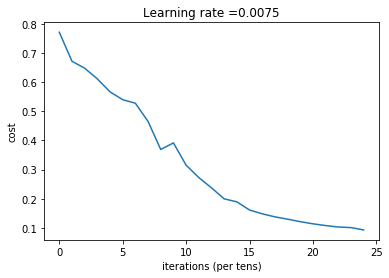

In [25]:
layers_dims = [12288, 20, 7, 5, 1]

d = model(train_x, train_y, layers_dims, num_iterations = 2500, print_cost = True)

In [26]:
pred_train = predict(train_x, train_y, d)

Accuracy: 0.9856459330143539


In [27]:
pred_test = predict(test_x, test_y, d)

Accuracy: 0.8


We can see that there is a lot of variance. 

So lets use regularization

## L2 Regularization

Cost after iteration 0: 0.811790
Cost after iteration 500: 0.618118
Cost after iteration 1000: 0.329455
Cost after iteration 1500: 0.203644
Cost after iteration 2000: 0.164076


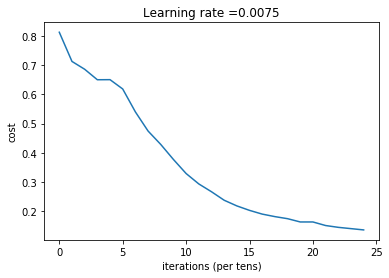

Accuracy: 0.8400000000000001


In [28]:
d = model(train_x, train_y, layers_dims, num_iterations = 2500, print_cost = True, regularization = True, lambd = 0.45525)
predicted = predict(test_x, test_y, d)

### Test on a image

C:\Users\samud\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  


Accuracy: 1.0
Prediction: non-cat picture.


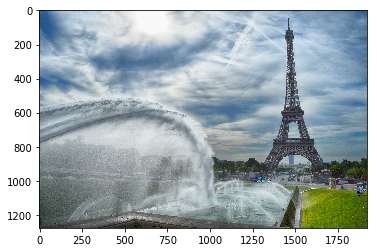

In [29]:
import scipy
from scipy import ndimage
my_image = "my_image.jpg" 
my_label_y = [0] 

fname = "images/" + my_image
image = np.array(plt.imread(fname))
my_image = scipy.misc.imresize(image, size=(num_px,num_px)).reshape((num_px*num_px*3,1))
my_image = my_image/255.
my_predicted_image = predict(my_image, my_label_y, d)
plt.imshow(image)

print ("Prediction: " + classes[int(np.squeeze(my_predicted_image))].decode("utf-8") +  " picture.")

C:\Users\samud\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  


Accuracy: 1.0
Prediction: cat picture.


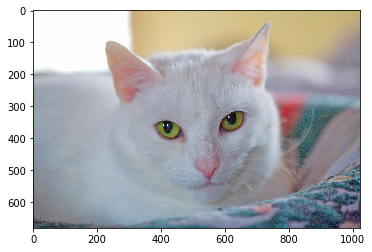

In [30]:
my_image = "my_image2.jpg" 
my_label_y = [1] 

fname = "images/" + my_image
image = np.array(plt.imread(fname))
my_image = scipy.misc.imresize(image, size=(num_px,num_px)).reshape((num_px*num_px*3,1))
my_image = my_image/255.
my_predicted_image = predict(my_image, my_label_y, d)
plt.imshow(image)

print ("Prediction: " + classes[int(np.squeeze(my_predicted_image))].decode("utf-8") +  " picture.")